In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from pp5.plot import ramachandran, savefig

In [4]:
from pp5.distributions.vonmises import BvMMixtureDiscreteDistribution
from pp5.distributions.vonmises import BvMKernelDensityEstimator

## Estimation of BvM Mixture with Kernel Density

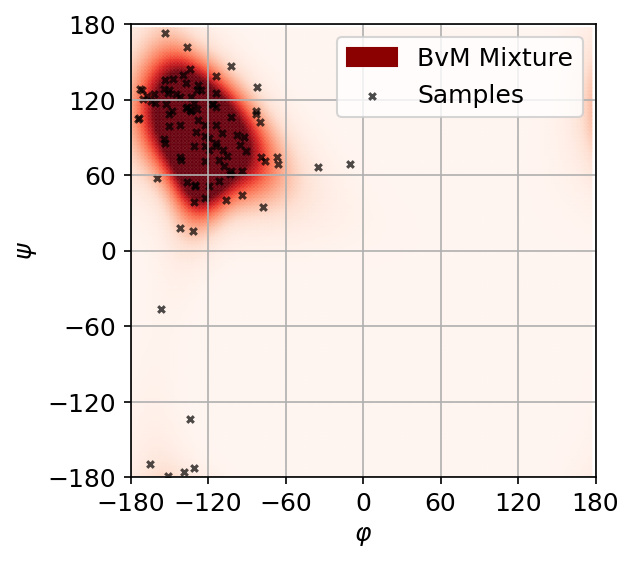

In [5]:
PI = np.pi
grid_size = 128
n_samples = 1000
ramachandran_kw=dict(vmin=0, vmax=5e-4)

k1 = [
    np.array(3,),
    np.array(18,),
]
k2 = [
    np.array(3,),
    np.array(2,),
]
A = [
    np.array([
        [0.0,3.0],
        [2.0,0.0]
    ]),
    np.array([
        [0.0,1.0],
        [6.0,0.0]
    ]),
]
mu = [
    np.array([-PI*0.8, PI/3]),
    np.array([-PI*0.8, PI/3]),   # <- we'll shift this
]
alpha = [.75, .25]
bvm = BvMMixtureDiscreteDistribution(
    k1=k1, k2=k2, A=A,
    mu=mu, alpha=alpha,
    two_pi=False, gridsize=grid_size
)

kde = BvMKernelDensityEstimator(n_bins=grid_size, k1=30, k2=30, k3=0)

fig, ax = bvm.plot(samples=100, ramachandran_kw=ramachandran_kw)

In [6]:
def plot_kde(bvm, kde, n_samples):
    samples = bvm.sample(n_samples)
    pdf_kde = kde.estimate(samples[:, 0], samples[:, 1])

    print(f'diff norm = {np.linalg.norm(bvm.pdf - pdf_kde)}')
    return ramachandran([pdf_kde], legend_label=[f'KDE(n={n_samples})'], figsize=4, grid_2pi=False, **ramachandran_kw)

diff norm = 0.004162121580880057


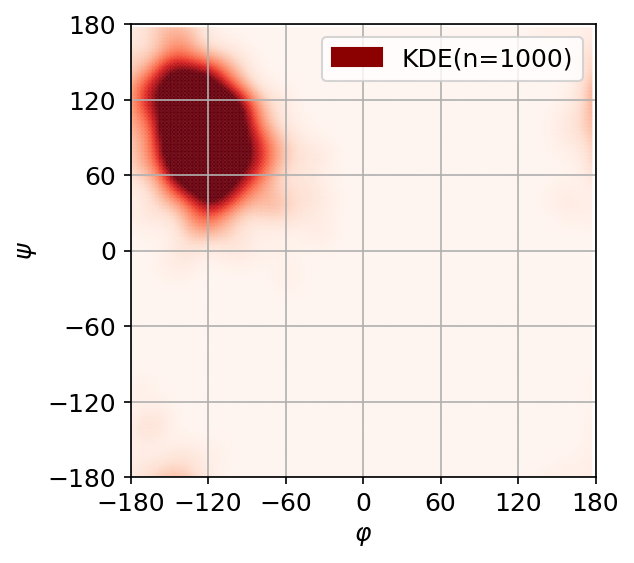

In [7]:
fig, ax = plot_kde(bvm, kde, n_samples=1000)

diff norm = 0.003561649443476488


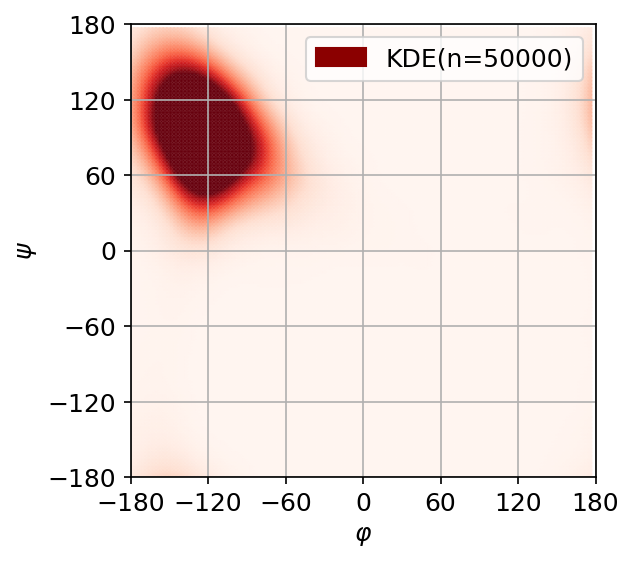

In [24]:
fig, ax = plot_kde(bvm, kde, 50000)

In [9]:
from typing import Callable

def bootstrapped_kde(
    kde: Callable,
    samples: np.ndarray,
    n_bootstrap=500,
    n_samples=None,
):
    """
    Calcualtes multiple KDE estimates from the same samples using a
    bootstrpping scheme.
    Each bootstrap iteration, a set of size n_samples is drawn with replacement
    from the given samples and a KDE is calcualted for it.
    
    :param kde: Callable to use for KDE estimation. WIll be called with (phi, psi) arrays.
    :param samples: An array of shape (N, 2) containing (phi, psi) samples.
    :param n_bootstrap: Number of bootstap iterations, i.e. number of times KDE will be calcualted.
    :param n_samples: Number of samples to draw from the given samples each bootstrap iteration.
    :returns: A tensor of shape (n_bootstrap, M, M) where M is the KDE grid size.
    """
    
    if not n_samples:
        n_samples, _ = samples.shape
    
    kdes = []
    
    for idx_bootstrap in range(n_bootstrap):
        idx_samples = np.random.choice(n_samples, size=n_bootstrap, replace=True)
        samples_subset = samples[idx_samples, :]
        kdes.append(
            kde(samples_subset[:,0], samples_subset[:,1])
        )
    
    return np.stack(kdes, axis=0)

def kde_dist_metric_l2(kde1: np.ndarray, kde2: np.ndarray):
    """
    Calculates a simple euclidean distance between two KDEs or batches of KDEs..
    :param kde1: First KDE. Can bbe of shape (N, N) (single) or (B, N, N) (batch).
    :param kde2: Second KDE. Can bbe of shape (N, N) (single) or (B, N, N) (batch).
    :return: Either a singe distance or B distances of shape (B,).
    """
    assert kde1.shape == kde2.shape
    assert kde1.ndim == 3 or kde1.ndim == 2
    
    bs_dists = np.nansum((kde1 - kde2) ** 2, axis=(1, 2))
    return bs_dists
    # return np.mean(bs_dists), np.std(bs_dists)

## Experiment

Simulating two codons, a reference codon $c_0$ and an experimental codon $c_i, i>0$, each with a angle distribution comprised of a mixture of two BvM distributions.
The reference codon's distribution remains fixed, while the other codon's distribution will be gradually changed for each experiment $i$, so that it becomes more distant from the reference.

Each time the second codon's distribution is changed, we'll calculate codon distance from data sampled from both codons, at multiple different values of sample size.

In [114]:
import itertools as it

grid_size = 128

### Experiment configuration
n_experiments, n_sample_sizes = 12, 8
mu_limit = np.pi * (1.2)
alpha_limit = 0.25
mu_offsets = np.linspace(0, mu_limit, endpoint=True, num=n_experiments)
alpha_offsets = np.linspace(0, alpha_limit, endpoint=True, num=n_experiments)
sample_sizes = np.logspace(4, 11, base=2, endpoint=True, num=n_sample_sizes, dtype=np.int)
n_bootstrap = 500
n_bootstrap_samples = None
k_experiment_repeats = 50
experiments_iter = list(it.product(enumerate(range(n_experiments)), enumerate(sample_sizes)))
savefig_kw = dict(dpi=150, facecolor='w', bbox_inches='tight')

# Distribution parameters for the base codon.
# The location of the first mode will be gradually changed for the second one.
bvm_params0 = dict(
    k1=k1, k2=k2, A=A, mu=mu, alpha=alpha, two_pi=False, gridsize=grid_size,
)

# Base codon's distribution
bvm0 = BvMMixtureDiscreteDistribution(
    **bvm_params0
)

# KDE used for estimation
kde = BvMKernelDensityEstimator(n_bins=grid_size, k1=30, k2=30, k3=0)

def bvm_params_step(bvm_params, step_idx):
    mu_offset = mu_offsets[step_idx]
    alpha_offset = alpha_offsets[step_idx]
    
    bvm_params1 = bvm_params.copy()
    bvm_params1['mu'] = [
        bvm_params1['mu'][0],
        bvm_params1['mu'][1] - np.array([-mu_offset, mu_offset]),
    ]
    bvm_params1['alpha'] = [
        bvm_params1['alpha'][0] - alpha_offset,
        bvm_params1['alpha'][1] + alpha_offset,
    ]
    return bvm_params1

We'll plot the synthetic codon distributions & calculate ground-truth distances.

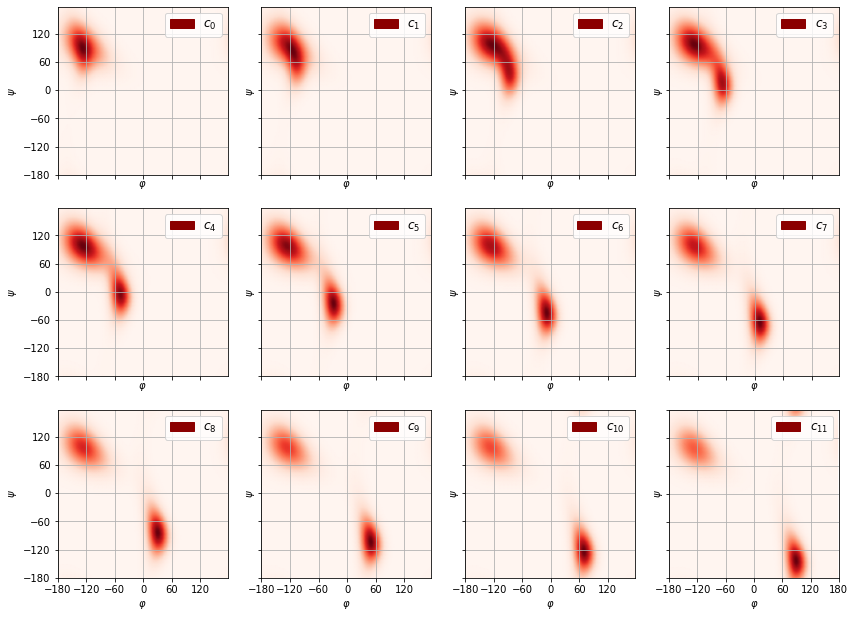

In [115]:
gt_dists = np.zeros(n_experiments)
figs_per_row = 4
nrows, ncols = int(np.ceil(n_experiments/figs_per_row)), figs_per_row
fig, ax = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*3.5),
    sharex=True, sharey=True
)

for i, j in it.product(range(nrows), range(ncols)):
    exp_idx = i*ncols + j
    if exp_idx >= n_experiments:
        ax[i,j].set_axis_off()
        continue

    # Create distribution of codon1, by shifting one mode in codon0's distribution
    bvm_params1 = bvm_params_step(bvm_params0, exp_idx)
    bvm1 = BvMMixtureDiscreteDistribution(**bvm_params1)
    
    # Plot it
    ramachandran([bvm1.pdf], [rf'$c_{{{exp_idx}}}$'], ax=ax[i,j])
    
    # Calculate ground truth distance
    bs_dists = kde_dist_metric_l2(
        np.expand_dims(bvm0.pdf, 0), np.expand_dims(bvm1.pdf, 0),
    )
    gt_dists[exp_idx] = np.mean(bs_dists)


fig.savefig("03_plots/01-codon_dists.png", **savefig_kw)

In [116]:
# Sort gt_dists and mu_offsets so that gt distance for each offset is increasing
idx_sorted_gt_dists = np.argsort(gt_dists)
gt_dists = gt_dists[idx_sorted_gt_dists]
mu_offsets = mu_offsets[idx_sorted_gt_dists]
alpha_offsets = alpha_offsets[idx_sorted_gt_dists]

pd.DataFrame({'gt_dists':gt_dists,'mu_offsets':mu_offsets,'alpha_offsets':alpha_offsets})

,gt_dists,mu_offsets,alpha_offsets
0,0.000000,0.000000,0.000000
1,0.000078,0.342719,0.022727
2,0.000183,0.685438,0.045455
3,0.000235,1.028158,0.068182
4,0.000270,1.370877,0.090909
5,0.000305,1.713596,0.113636
6,0.000340,2.056315,0.136364
7,0.000377,2.399034,0.159091
8,0.000416,2.741754,0.181818
9,0.000458,3.084473,0.204545


In [117]:
def single_experiment(exp_idx, sample_size, verbose=False):
    assert exp_idx < n_experiments
    
    # Create distribution of codon1, by shifting one mode in codon0's distribution
    bvm_params1 = bvm_params_step(bvm_params0, exp_idx)
    bvm1 = BvMMixtureDiscreteDistribution(**bvm_params1)
    
    # Sample from both distributions
    samples0, samples1 = [
        bvm.sample(sample_size) for bvm in [bvm0, bvm1]
    ]
    
    # Compute a bootstrapped KDE from each codon's distribution
    bs_kde0, bs_kde1 = [
        bootstrapped_kde(kde, samples, n_bootstrap, n_bootstrap_samples)
        for samples in [samples0, samples1]
    ]

    # Calculate codon distance
    bs_dists = []
    for k in range(k_experiment_repeats):
        dist_k = kde_dist_metric_l2(
            # Note: permutation is along the first axis, which is B
            # So for each k, different KDEs will be matched for the distance calculation
            np.random.permutation(bs_kde0),
            np.random.permutation(bs_kde1)
        )
        # dist_k has shape (B,)
        bs_dists.append(dist_k)
        
    if verbose:
        print('.', end='')
        
    # output has shape (K, B)
    result = np.stack(bs_dists, axis=0) 
    assert result.shape == (k_experiment_repeats, n_bootstrap)
    return result

In [118]:
import time
import multiprocessing as mp
from pp5.parallel import yield_async_results

start_time = time.time()
mp_ctx = mp.get_context("fork")

###
# Run multi-process
with mp_ctx.Pool(processes=8) as pool:

    async_results = {}
    for (i, exp_idx), (n, sample_size) in experiments_iter:
        res = pool.apply_async(
            single_experiment,
            args=[exp_idx, sample_size],
            kwds=dict(verbose=True)
        )
        async_results[(i,n)] = res

    cdists = {} # (i, n) -> (K, B) distances for experiment i with sample size n
    d2_mu_std = np.zeros((n_experiments, n_sample_sizes), dtype=np.complex64)
    for res in yield_async_results(async_results, wait_time_sec=0.1, max_retries=10000):
        # bs_dists is (K, B)
        (i, n), bs_dists = res
        
        # Save the full experiment results
        cdists[i, sample_sizes[n]] = bs_dists
        
        # Create a distance matrix for plotting, average over K and B here
        d2_mu_std[i, n] = np.mean(bs_dists) + 1j * np.std(bs_dists)

print(f'\nDONE, elapsed={time.time()-start_time:.2f} sec')

................................................................................................
DONE, elapsed=1779.81 sec


Plot the mean and std for distances between each experimental codon ($c_{i}, i>0$) distribution and the reference codon's ($c_0$) distribution.

[2020-11-11 14:28:41,326  matplotlib.mathtext]    INFO >> Substituting symbol E from STIXNonUnicode
[2020-11-11 14:28:44,632  matplotlib.mathtext]    INFO >> Substituting symbol E from STIXNonUnicode
[2020-11-11 14:28:44,846  matplotlib.mathtext]    INFO >> Substituting symbol E from STIXNonUnicode
[2020-11-11 14:28:45,021  matplotlib.mathtext]    INFO >> Substituting symbol E from STIXNonUnicode


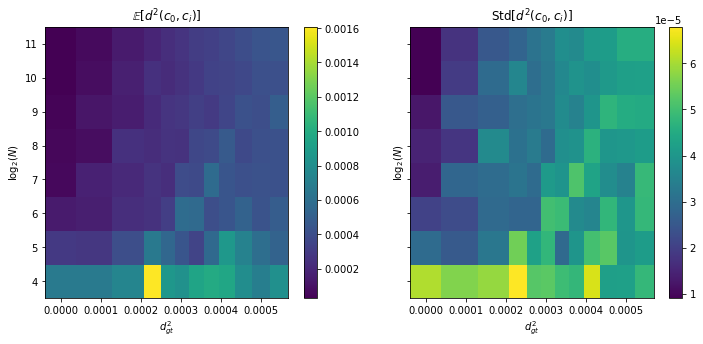

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)

m1 = ax[0].pcolormesh(gt_dists, np.log2(sample_sizes), np.real(d2_mu_std.T), shading='nearest')
ax[0].set_title(r'$\mathbb{E}[d^2(c_0,c_i)]$')
plt.colorbar(m1, ax=ax[0],);

m2 = ax[1].pcolormesh(gt_dists, np.log2(sample_sizes), np.imag(d2_mu_std.T), shading='nearest')
ax[1].set_title(r'$\mathrm{Std}[d^2(c_0,c_i)]$')
plt.colorbar(m2, ax=ax[1]);

for a in ax:
    a.set_xlabel('$d^2_{gt}$')
    a.set_ylabel('$\\log_2(N)$')
    
fig.savefig('03_plots/02-d2_mean_std.png', **savefig_kw)

For each experimental codon ($c_{i}, i>0$) distribution and each sample size, plot the distribution of distances of: 
- $d^2(c_0, c_0)$: This is the null-hypothesis distribution (blue)
- $d^2(c_0, c_i)$: This is the experimental measurements distribution (orange)

We'll also plot the CDFs and calcalate the equal-error rate.

In [120]:
from tqdm import tqdm

  0%|          | 24/4800 [00:04<14:42,  5.41it/s]/Users/aviv/miniconda3/envs/proteins/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
  2%|▏         | 96/4800 [00:12<07:38, 10.25it/s]/Users/aviv/miniconda3/envs/proteins/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
100%|██████████| 4800/4800 [00:14<00:00, 339.76it/s] 


DONE calculating EERs, saving figure...


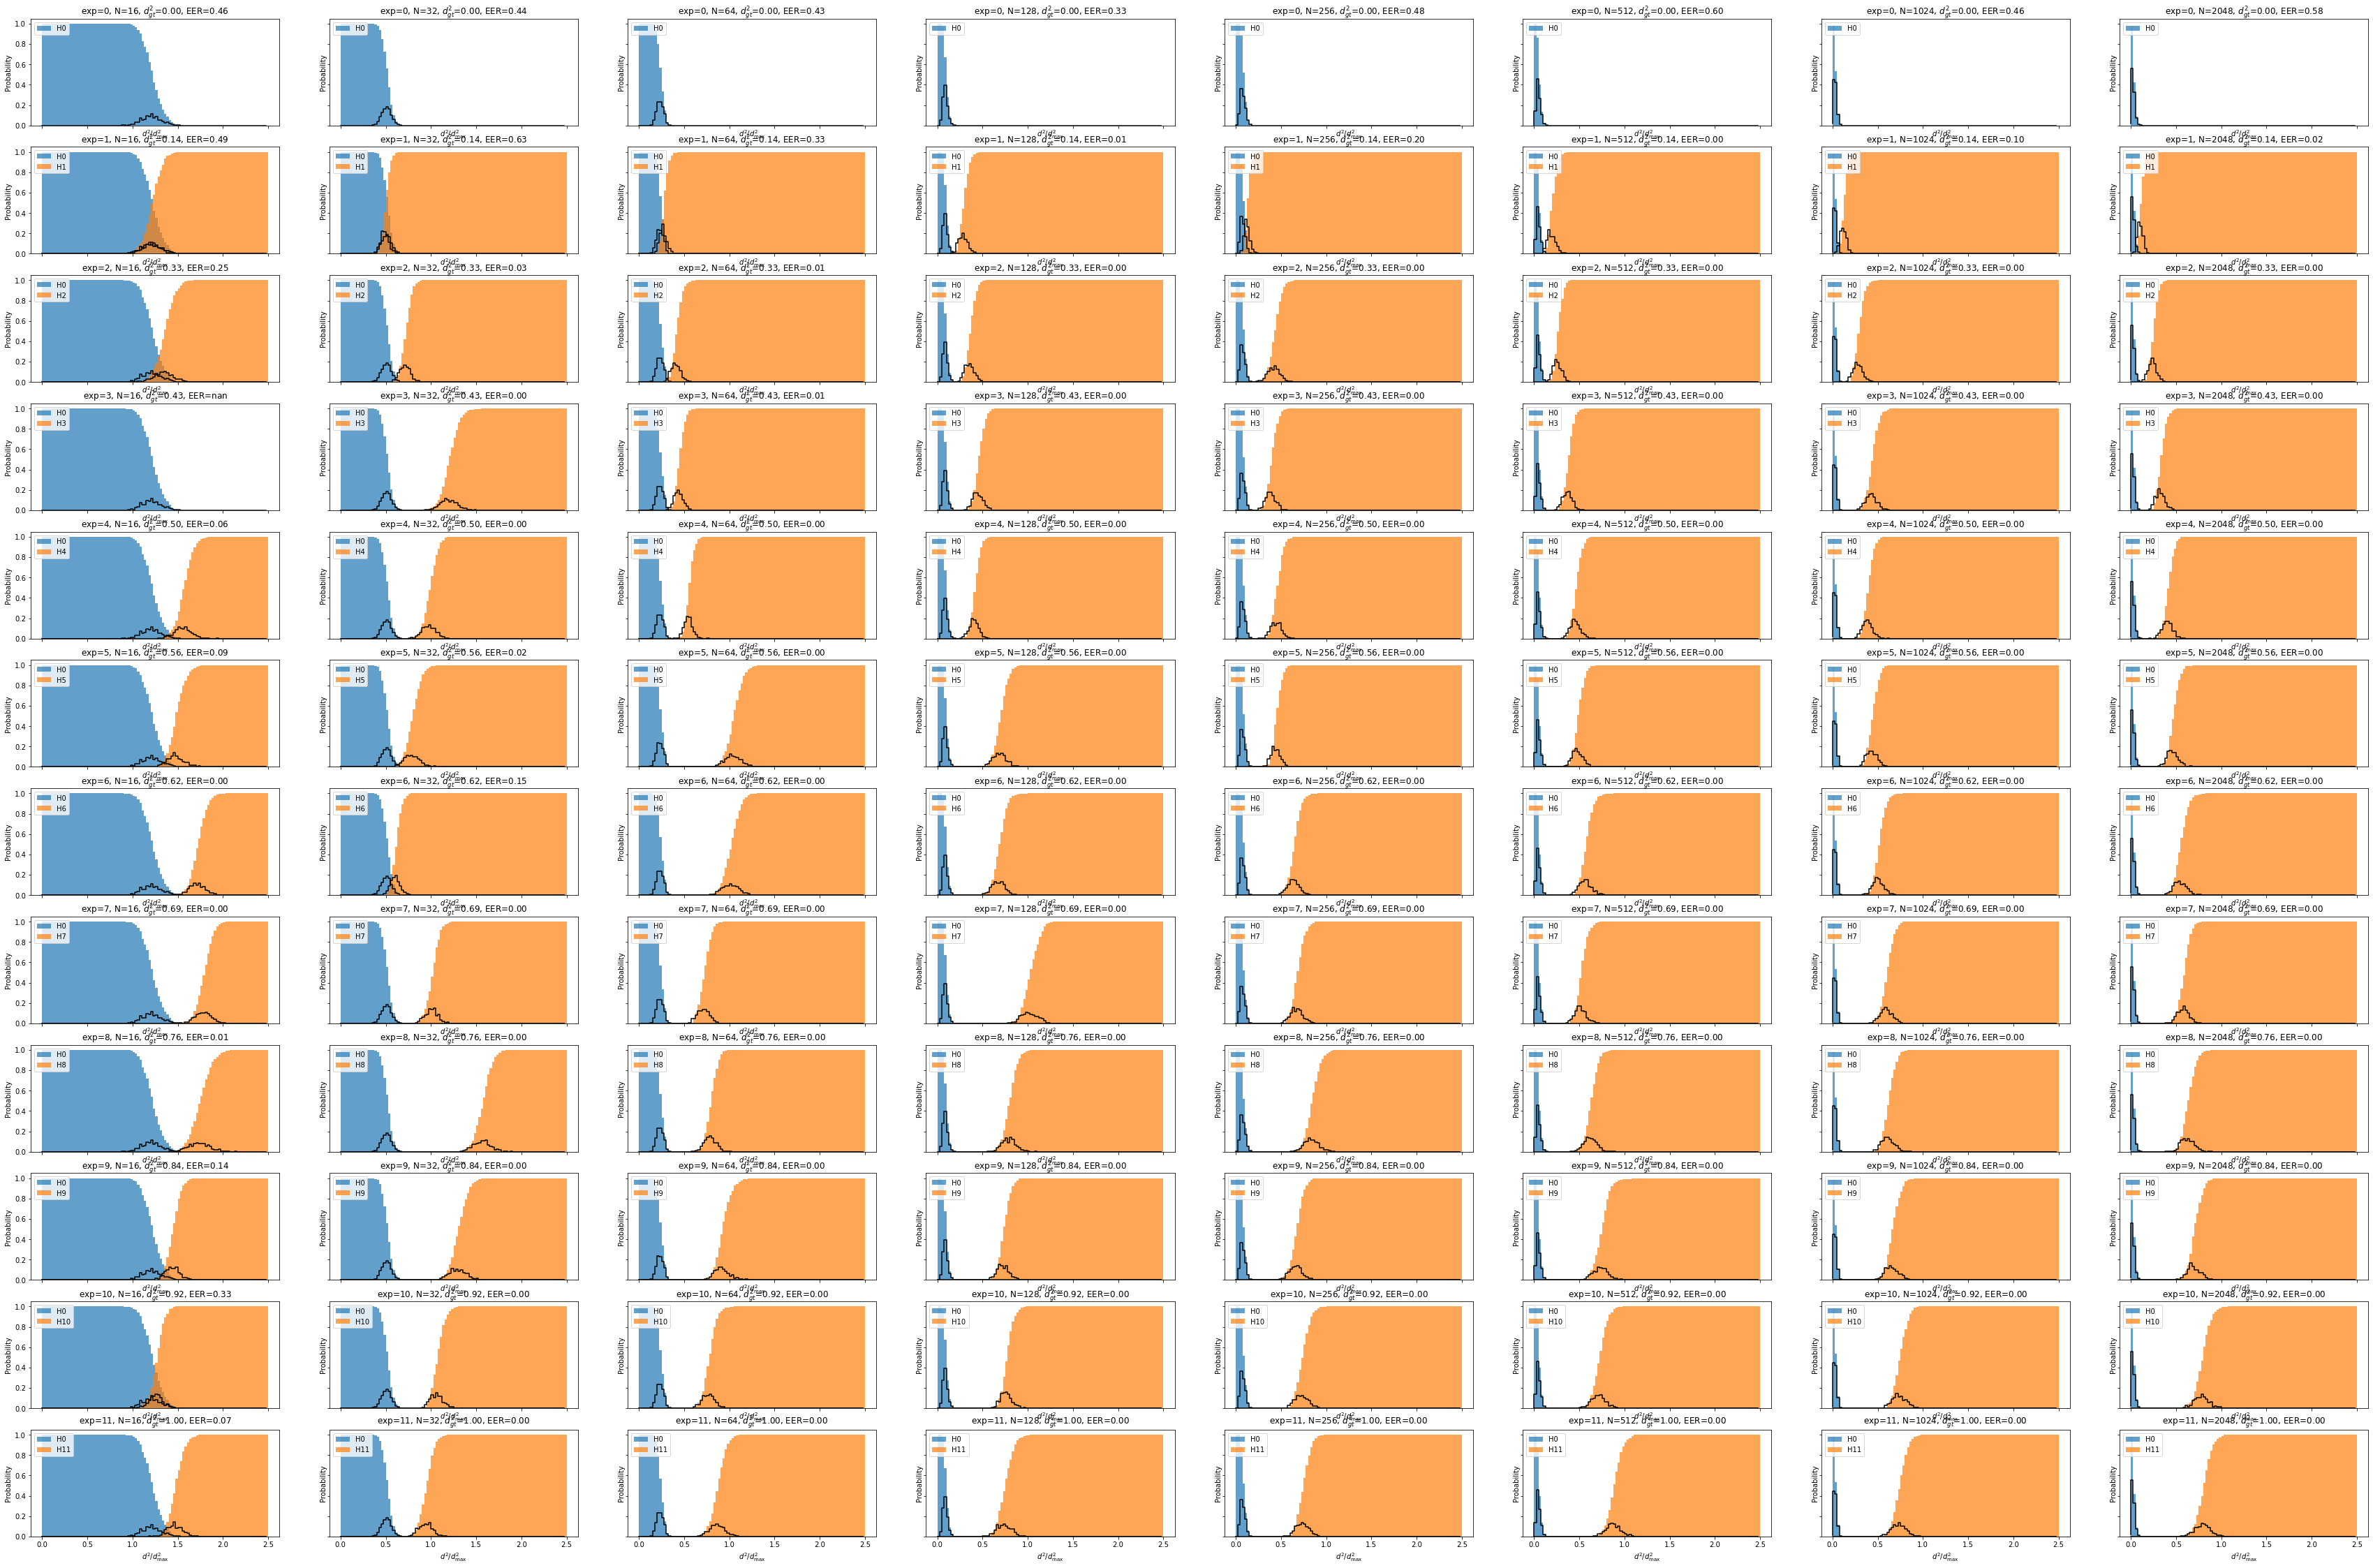

In [131]:
max_gt_dist = gt_dists[-1]
hist_kw = dict(
    bins=100,
    range=(0, 2.5), # normalized in terms of maximal gt dist
    density=True,
)
bar_kw = dict(
    alpha=0.7,
    align='edge'
)

fig, axes = plt.subplots(
    n_experiments, n_sample_sizes,
    figsize=(5*n_experiments, 5*n_sample_sizes),
    sharex=True, sharey=True,
)

EER = np.ones((k_experiment_repeats, n_experiments, n_sample_sizes), dtype=np.float32)

k_experiments_iter = list(it.product(
    range(k_experiment_repeats), experiments_iter
))
for k, ((i, exp_idx), (n, sample_size)) in tqdm(k_experiments_iter):
    # Get H0 (null hypothesis) and H1 (measurement) distances
    # H0 is the distribution of distances when measuring a codon's distance from itself.
    # Normalize w.r.t. maximal ground-truth distance
    h0_dists = cdists[(0, sample_size)][k, :] / max_gt_dist
    h1_dists = cdists[(i, sample_size)][k, :] / max_gt_dist
    
    # Compute histograms of the distances
    h0, bins, *_ = np.histogram(h0_dists, **hist_kw)
    h1, bins, *_ = np.histogram(h1_dists, **hist_kw,)
    bins = bins[:-1]
    dx = np.diff(bins)[0]
    
    # Estimate PDF
    h0 /= np.sum(h0)
    h1 /= np.sum(h1)
    
    # Estimate 1-CDF(H0) and CDF(H1)
    cdf0 = 1 - np.cumsum(h0)
    cdf1 = np.cumsum(h1)
    
    # Calculate EER
    argmin_diff = np.argmin(np.abs(cdf0-cdf1))
    EER[k, i, n] = cdf1[argmin_diff]
    
    # Plot
    if k == 0:
        ax = axes[i, n]
        ax.step(bins, h0, 'k')
        ax.bar(x=bins, height=cdf0, width=dx, label='H0', **bar_kw)
        if i > 0:
            ax.step(bins, h1, 'k')
            ax.bar(x=bins, height=cdf1, width=dx, label=f'H{i}', **bar_kw)
        ax.set_title(
            f"exp={i}, N={sample_sizes[n]}, "
            f"$d^2_{{gt}}$={gt_dists[i]/max_gt_dist:.2f}, EER={EER[k, i, n]:.2f}"
        )
        ax.legend(loc="upper left")
        ax.set_xlabel('$d^2/d^2_{\\max}$')
        ax.set_ylabel('Probability')
    
print('DONE calculating EERs, saving figure...')
fig.savefig('03_plots/03-eer.png', **savefig_kw)

Find the smallest ground-truth distance ($d_{\min}(N)$) which is seperable at a given confidence level specified in terms of EER, as a function of the sample size ($N$).

In [122]:
assert EER.shape == (k_experiment_repeats, n_experiments, n_sample_sizes)
EER.shape

(50, 12, 8)

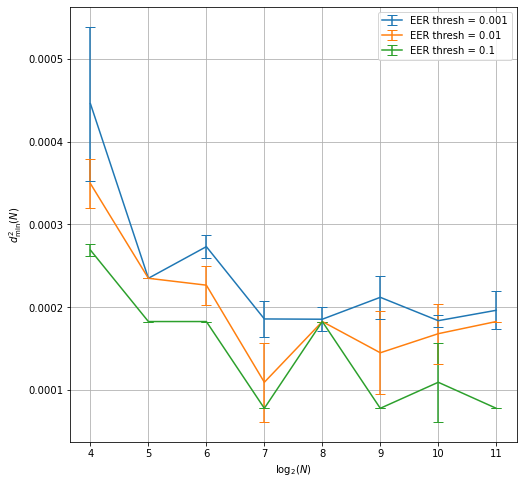

In [139]:
eer_thresholds = reversed([0.1, 0.01, 0.001])

log2_N = np.log2(sample_sizes)

fig, ax = plt.subplots(1, 1, figsize=(8,8))

for eer_thresh in eer_thresholds:
    
    d_min = max_gt_dist * np.ones((k_experiment_repeats, n_sample_sizes))
    
    for k, n in it.product(range(k_experiment_repeats), range(n_sample_sizes)):
        eer_kn = EER[k, :, n]

        for i in range(1, n_experiments):
            
            # If the EER of experiment i is smaller than the threshold,
            # then the (normalized) g.t. distance of experiment i is d_min
            if eer_kn[i] <= eer_thresh:
                d_min[k, n] = gt_dists[i]
                break
    
    # normalize by the maximal g.t. distance
    #d_min /= max_gt_dist
    d_min_mu, d_min_std = np.mean(d_min, axis=0), np.std(d_min, axis=0)
    ax.errorbar(
        log2_N, d_min_mu, yerr=d_min_std,
        label=f'EER thresh = {eer_thresh}',
        capsize=5,
    )
    
ax.set_xticks(np.arange(log2_N[0], log2_N[-1]+1, step=1))
ax.set_xlabel('$\\log_2(N)$')
# ax.set_ylabel('$d^2_{\\min}(N) / d^2_{\\max}$')
ax.set_ylabel('$d^2_{\\min}(N)$')
ax.legend()
ax.grid()
fig.savefig('03_plots/04-d_min.png', **savefig_kw)

In [126]:
d_min.shape

(50, 8)

In [141]:
EER.shape

(50, 12, 8)